**Импорт библиотек**


In [ ]:
%pip install rouge_score
%pip install evaluate
%pip install --upgrade -q wandb

In [23]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, pipeline, set_seed
from transformers import DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments

import datasets
from datasets import load_metric, Dataset
from datasets import DatasetDict

from tqdm import tqdm

import wandb

# Заменить на RAZDEL (возможно)
# import nltk
# from nltk.tokenize import sent_tokenize
# nltk.download("punkt")

import warnings
warnings.filterwarnings('ignore')

Загрузка предобученной модели

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_ckpt = "IlyaGusev/mbart_ru_sum_gazeta"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [13]:
test_parquet_file = "data\\test-00000-of-00001.parquet"
train1_parquet_file = "data\\train-00000-of-00002.parquet"
train2_parquet_file = "data\\train-00001-of-00002.parquet"
valodation_parquet_file = "data\\validation-00000-of-00001.parquet"

df = pd.read_parquet(valodation_parquet_file)

In [14]:
df.head()

,info,summary
0,В ближайшее воскресенье в легкоатлетическом ма...,В ближайшее воскресенье в Москве в 20-й раз в ...
1,Страны НАТО и члены Совбеза ООН устроили перек...,Страны Запада приступили к детальному планиров...
2,В понедельник прокуратура Петербурга официальн...,"Проверив треть питерских НКО, финансируемых из..."
3,"Обязательный масочный режим, который был введе...",Соблюдение обязательных мер профилактики корон...
4,Обвинительный приговор Ходорковскому и Лебедев...,Реформа правосудия по Медведеву буксует. Финал...


In [15]:
# removing nans if any
df.dropna(inplace=True)
df.isnull().sum()

info       0
summary    0
dtype: int64

In [35]:
# функция для подсчета слов в каждом образце
def word_count(sentence):
    sentences = sentence.split()
    return len(sentences)

# создание новых столбцов с количеством слов
df['num_words_info'] = df['info'].apply(word_count)
df['num_words_summary'] = df['summary'].apply(word_count)
df.head()

,info,summary,num_words_info,num_words_summary
0,В ближайшее воскресенье в легкоатлетическом ма...,В ближайшее воскресенье в Москве в 20-й раз в ...,691,36
1,Страны НАТО и члены Совбеза ООН устроили перек...,Страны Запада приступили к детальному планиров...,466,45
2,В понедельник прокуратура Петербурга официальн...,"Проверив треть питерских НКО, финансируемых из...",761,37
3,"Обязательный масочный режим, который был введе...",Соблюдение обязательных мер профилактики корон...,543,47
4,Обвинительный приговор Ходорковскому и Лебедев...,Реформа правосудия по Медведеву буксует. Финал...,506,17
...,...,...,...,...
7183,Российский Forbes опубликовал рейтинг самых вл...,Журнал Forbes составил рейтинг 100 самых влият...,624,39
7184,Следственный отдел по Хилокскому району СУ СКР...,В Забайкальском крае задержали двух подозревае...,510,30
7185,В апреле 2012 года российская экономика выросл...,Российская экономика сокращается второй месяц ...,537,35
7186,Кремль придерживается «устоявшейся практики» и...,Дискуссии о сокращении продолжительности новог...,524,41


In [18]:
# получение статистической информации о длине слова
# count — количество ненулевых значений в столбце.
# mean — среднее значение.
# std — стандартное отклонение (дисперсия?).
# min — минимальное значение.
# 25% — первый квартиль (ниже которого находятся 25% данных) Q1.
# 50% — медиана         (ниже которого находятся 50% данных) Q2.
# 75% — третий квартиль (ниже которого находятся 75% данных) Q3.
# max — максимальное значение.

df.describe()

,num_words_info,num_words_summary
count,7188.000000,7188.000000
mean,533.099054,38.201029
std,260.703231,15.023624
min,7.000000,1.000000
25%,434.750000,28.000000
50%,560.000000,39.000000
75%,665.000000,49.000000
max,1268.000000,76.000000


Upper whisker: 1010.0
Q3: 665.0
Q2: 560.0
Q1: 434.75
Lower whisker: 90.0


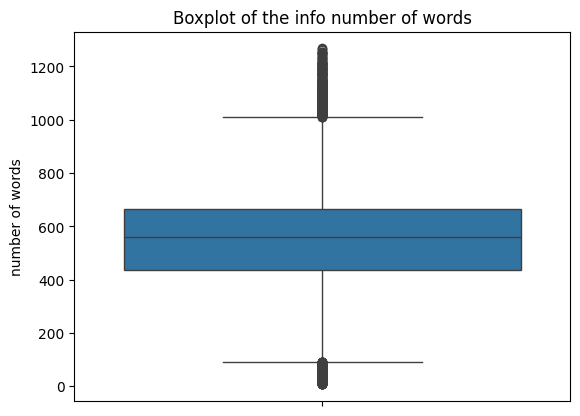

In [30]:
sns.boxplot(df["num_words_info"])
plt.ylabel("number of words")
plt.title("Boxplot of the info number of words")

lines = plt.gca().lines[:6]
all_lines = [lines[i].get_ydata()[0] for i in range(5)]

Q1,Q3,info_lower_whisker,info_upper_whisker, Q2 = all_lines

print("Upper whisker:", info_upper_whisker)
print("Q3:", Q3)
print("Q2:", Q2)
print("Q1:", Q1)
print("Lower whisker:", info_lower_whisker)

Upper whisker: 76.0
Q3: 49.0
Q2: 39.0
Q1: 28.0
Lower whisker: 1.0


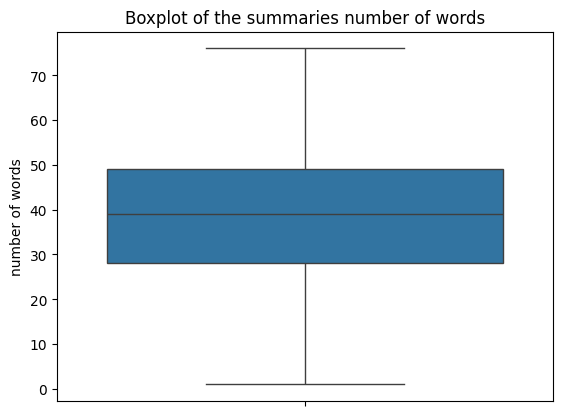

In [31]:
sns.boxplot(df["num_words_summary"])
plt.ylabel("number of words")
plt.title("Boxplot of the summaries number of words")

lines = plt.gca().lines[:6]
all_lines = [lines[i].get_ydata()[0] for i in range(5)]

Q1,Q3,summary_lower_whisker,summary_upper_whisker, Q2 = all_lines

print("Upper whisker:", summary_upper_whisker)
print("Q3:", Q3)
print("Q2:", Q2)
print("Q1:", Q1)
print("Lower whisker:", summary_lower_whisker)

In [32]:
# Удаление образцов очень длинных последовательностей
new_df = df[(df['num_words_summary'] <= summary_upper_whisker) & (df['num_words_info'] <= info_upper_whisker)]
new_df

,info,summary,num_words_info,num_words_summary
0,В ближайшее воскресенье в легкоатлетическом ма...,В ближайшее воскресенье в Москве в 20-й раз в ...,691,36
1,Страны НАТО и члены Совбеза ООН устроили перек...,Страны Запада приступили к детальному планиров...,466,45
2,В понедельник прокуратура Петербурга официальн...,"Проверив треть питерских НКО, финансируемых из...",761,37
3,"Обязательный масочный режим, который был введе...",Соблюдение обязательных мер профилактики корон...,543,47
4,Обвинительный приговор Ходорковскому и Лебедев...,Реформа правосудия по Медведеву буксует. Финал...,506,17
...,...,...,...,...
7183,Российский Forbes опубликовал рейтинг самых вл...,Журнал Forbes составил рейтинг 100 самых влият...,624,39
7184,Следственный отдел по Хилокскому району СУ СКР...,В Забайкальском крае задержали двух подозревае...,510,30
7185,В апреле 2012 года российская экономика выросл...,Российская экономика сокращается второй месяц ...,537,35
7186,Кремль придерживается «устоявшейся практики» и...,Дискуссии о сокращении продолжительности новог...,524,41


**Подготовка данных**

In [34]:
# Удаление столбцов и перемешивание
new_df.drop(columns=["num_words_info", "num_words_summary"], inplace=True)
new_df = new_df.sample(frac=1)
new_df.reset_index(drop=True, inplace=False)

,info,summary
0,США направили в Персидский залив группу корабл...,США отправляют в Персидский залив авианосец Jo...
1,"Молли: У тебя есть гитара?\r\nШон: да, старый\...",Шон одолжит Молли свою гитару и научит ее игра...
2,В битве лидеров Восточной конференции вновь си...,«Нью-Йорк Никс» продлил свою победную серию до...
3,В 2020 год президент США Дональд Трамп вошел с...,В преддверии президентских выборов 2020 года Д...
4,Томский областной суд в понедельник огласил пр...,Бывший мэр Томска Александр Макаров приговорен...
...,...,...
6926,"Конец 1980-х. Киев. Цветут каштаны, власти вор...",Вышла книга русскоязычного киевского писателя ...
6927,Хлоя: Я очень беспокоюсь о Марке.\r\nСиенна: П...,Хлоя беспокоится о Марке. Марк в последнее вре...
6928,Медиакорпорация Liberty Interactive выкупила к...,Один из самых популярных туристических интерне...
6929,"Арест бывшего премьер-министра Украины, основн...",Сторонники бывшего премьер-министра Юлии Тимош...


In [37]:
# разделение данных на обучающие и тестовые
# (есть в отдельном файле, нужно сконкатенировать)

ratio = 0.8
split = int(len(new_df)*ratio)

train_df = new_df.iloc[:split]
test_df = new_df.iloc[split:]

In [38]:
# преобразование фрейма данных в DatasetDict
train_dataset = Dataset.from_dict(train_df)
test_dataset = Dataset.from_dict(test_df)
dataset = datasets.DatasetDict({"train":train_dataset,"test":test_dataset})
dataset

DatasetDict({
    train: Dataset({
        features: ['info', 'summary'],
        num_rows: 5544
    })
    test: Dataset({
        features: ['info', 'summary'],
        num_rows: 1387
    })
})

In [40]:
max_input_length = int(info_upper_whisker)
max_target_length = int(summary_upper_whisker)

def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["article"],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        examples["summary"], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/5544 [00:00<?, ? examples/s]


NameError: name 'tokenizer' is not defined

In [ ]:
import evaluate

rouge_score = evaluate.load("rouge")

def compute_metrics(eval_pred):
    # Предсказания и истинные метки
    predictions, labels = eval_pred
    
    # Декодировать сгенерированное резюме в текст
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    # Значения -100 в метках заменяются на tokenizer.pad_token_id
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    
    # Декодировать референс резюме в текст
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # ROUGE ожидает, чтобы после каждого предложения добавлялся перевод строки
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    
    # Compute ROUGE scores
    result = rouge_score.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    
    return {k: round(v, 4) for k, v in result.items()}

**Генерация Summaries с использованием Pipline**

In [ ]:
summarizer = pipeline("summarization", model=model_ckpt)

def print_summary(idx):
    article = dataset["test"][idx]["article"]
    summary = dataset["test"][idx]["summary"]
    g_summary = summarizer(dataset["test"][idx]["article"])[0]["summary_text"]
    score = rouge_score.compute(predictions=[g_summary], references=[summary])
    scores = {k: round(v, 4) for k, v in score.items()}
    print(f"'>>> Article: {article}'")
    print(f"\n'>>> Summary: {summary}'")
    print(f"\n'>>> Generated Summary: {g_summary}'")
    print(f"\n'>>> ROUGE Score: {scores}'")

print_summary(5)

**Тонкая настройка**

In [ ]:
# Создание data_collator

# data_collator - это функция,
# которая принимает пакет данных и преобразует его в формат,
# подходящий для обучения модели

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)


# Удаление столбцов имён столбцов
tokenized_datasets = tokenized_datasets.remove_columns(dataset["train"].column_names)

In [ ]:
batch_size = 8
num_train_epochs = 8
# Показать training loss для каждой эпохи
logging_steps = len(tokenized_datasets["train"]) // batch_size
model_name = model_ckpt

args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name}-finetuned-BBC",
    evaluation_strategy="epoch",
    learning_rate=5.6e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    logging_steps=logging_steps,
    push_to_hub=True,)

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,)

**Обучение**

In [ ]:
trainer.train()